In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from IPython.display import display

plt.style.use("seaborn-pastel")
plt.rcParams['figure.figsize'] = (10, 7)

In [2]:
df = pd.read_csv('data/streaming_history.csv', parse_dates=['endTime'])
tracks_df = pd.read_csv('data/tracks.csv', parse_dates=['album_release_date'])
features_df = pd.read_csv('data/features.csv')

df.dropna(inplace=True)

df = df.merge(tracks_df, left_on='id_', right_on='id_', suffixes=('stream_', 'track_'))\
       .merge(features_df, left_on='id_', right_on='id_', suffixes=('stream_', 'feature_'))

In [13]:
cols = [
    'popularity', 'danceability', 'energy', 'key', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

In [15]:
df = df.groupby('artist+track').aggregate({col: 'min' for col in cols})

In [25]:
norm_df = ((df - df.mean()) / df.std())

In [72]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=2.5, min_samples=3).fit(df)

In [73]:
labels = pd.Series(clustering.labels_, index=df.index)

<AxesSubplot:>

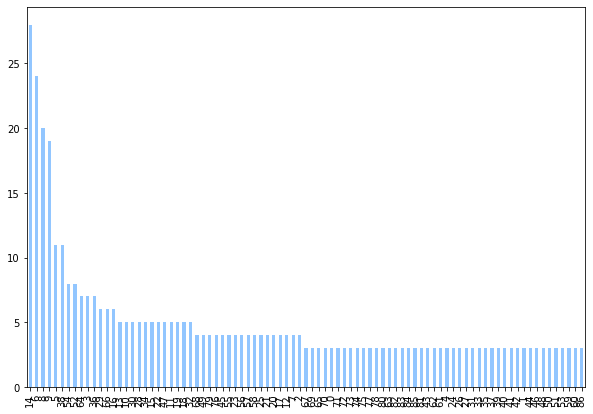

In [74]:
labels[labels != -1].value_counts().plot(kind='bar')

In [76]:
labels[labels == 14].index.tolist()

['Arcis The Arcane Arts',
 'Bent To Be Loved',
 'CHVRCHES Gun',
 "Charlotte Gainsbourg Ring-A-Ring O' Roses",
 'Chromatics Hands In The Dark',
 'Computer Magic Fuzz',
 'Crystal Castles 1991',
 'Crystal Castles Crymewave - VERDUGO Remix',
 'Crystal Castles Good Time',
 'Crystal Castles Reckless',
 "Dominique A J'avais oublié que tu m'aimais autant",
 'Franz Ferdinand Feel The Love Go',
 'Hatari Engin Miskunn',
 'HÆLOS Kyoto',
 'IAMX After Every Party I Die',
 'IAMX This Will Make You Love Again',
 'Marie Madeleine Swimming Pool',
 'Molecule Praïa Do Norte',
 'Mr. Oizo The Church',
 'Priest The Pit',
 'Rex The Dog Do You Feel What I Feel',
 'Róisín Murphy Narcissus - Extended Mix',
 'Spector All The Sad Young Men',
 'TR/ST Gone',
 'The Dø Keep Your Lips Sealed',
 'The Juan Maclean A Simple Design',
 'Yeasayer Fluttering In The Floodlights',
 'Zamilska Duel 35']